In [1]:
import boto3
import os
from dotenv import load_dotenv
from pdf2image import convert_from_path
import pandas as pd
import pdb
from merge_dataframes import merge_dataframes
import argparse
import matplotlib.pyplot as plt
# from get_column_borders import get_column_borders
# from get_row_borders import get_row_borders
from ocr_pipeline import get_column_borders, get_row_borders, check_y_coordinate_spacing, find_header_row, find_record_continued_from_previous_page, clean_image, get_dark_pixels, get_dividers

# Load AWS credentials and region from .env file
load_dotenv()

aws_access_key_id = os.getenv('AWS_ACCESS_KEY_ID')
aws_secret_access_key = os.getenv('AWS_SECRET_ACCESS_KEY')
region_name = os.getenv('AWS_REGION')


In [2]:
# Initialize the Textract client
client = boto3.client('textract', aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_access_key, region_name=region_name)

# # Create an argument parser
# parser = argparse.ArgumentParser(description="Generate an output path based on the PDF file path")
# parser.add_argument("pdf_path", help="Path to the PDF file")
# args = parser.parse_args()

pdf_path = '../data/input/praha_page_1.pdf'

# # Convert each page of the PDF to images and process with Textract
# images = convert_from_path(args.pdf_path)

images = convert_from_path(pdf_path)

# Define the subfolder name for CSV files
output_folder = 'data/output'

# Generate the CSV folder path by manipulating the PDF path
pdf_base_name = os.path.splitext(os.path.basename(pdf_path))[0]
csv_folder = os.path.join(output_folder, pdf_base_name)


In [3]:
image = images[0]
page_number = 1

# Define the CSV file path with the subfolder
csv_path = os.path.join(csv_folder, 'page_{}.csv'.format(page_number))

# Save the PNG image to a temporary file
image.save('page_{}.png'.format(page_number), 'PNG')

# Read the local image
with open('page_{}.png'.format(page_number), 'rb') as image_file:
    image_binary = image_file.read()

# Call Textract to analyze the image
response = client.detect_document_text(
    Document={
        'Bytes': image_binary
    }
)


In [4]:
# CELL 3

'''This section of code is used to find the header row with the numbers 1, 2, 3, 4, 5, 6, and 7 by
checking if there are 7 blocks in a row that meet those criteria.'''

numbers, last_sequence_block = find_header_row(response)


All seven expected numbers were found.
The y-coordinates are: [0.13683822751045227, 0.13703221082687378, 0.13695919513702393, 0.13696959614753723, 0.13640974462032318, 0.1362539380788803, 0.1356692910194397]
The mean distances between the y-coordinates are: [0.000438004732131958, 0.0005155454079310099, 0.0004581660032272339, 0.0004633665084838867, 0.0005094185471534729, 0.0005873218178749084, 0.0010745277007420857]


In [5]:
# CELL 4

'''From the seven numbers in the header row, we determine the borders of the columns each number is the head of.'''

x_dividers = []

# preprocess image
image = clean_image(image, response)

# get number of dark pixels in each column and row
row_list, column_list = get_dark_pixels(image)

# get the central x coordinate of each number in the header row
x_coordinates = []
for number in numbers:
    x_coordinates.append((number['Geometry']['BoundingBox']['Left'] + number['Geometry']['BoundingBox']['Width']/2) * image.size[0])

# get the column dividers
x_dividers, x_dividers_absolute = get_dividers(x_coordinates, column_list)





start, end:  282.83075001079123 503.26610325695947
319
start, end:  503.26610325695947 751.6768177547492
653
start, end:  751.6768177547492 958.1478885859251
843
start, end:  958.1478885859251 1222.9123321517836
1066
start, end:  1222.9123321517836 1614.1626889463514
1372
start, end:  1614.1626889463514 1971.6175489500165
1850


In [6]:
# Initialize seven groups to store LINE objects
line_groups = [[] for _ in range(7)]

for block in response['Blocks'][last_sequence_block:]:
    if block['BlockType'] == 'LINE':
        bbox = block['Geometry']['BoundingBox']
        left = bbox['Left']
        width = bbox['Width']

        # Calculate the center_x coordinate of the LINE object
        center_x = left + width / 2

        # Iterate through x_dividers to check where center_x belongs
        for i, divider in enumerate(x_dividers):
            if center_x < divider:
                # Append the LINE object to the corresponding list
                line_groups[i].append(block)
                break
        else:
            # If the center_x is greater than the last divider, assign it to the last group
            line_groups[-1].append(block)

In [7]:
# get the bottom coordinate of the first numbers object
y_coordinates = []

# append bottom coordinate of one of the numbers in the header row
y_coordinates.append((numbers[0]['Geometry']['BoundingBox']['Top'] + numbers[0]['Geometry']['BoundingBox']['Height']) * image.size[1])

print(len(line_groups[0]))
# append the bottom coordinate of all objects in line_groups[0]
for line in line_groups[0]:
    y_coordinates.append((line['Geometry']['BoundingBox']['Top'] + line['Geometry']['BoundingBox']['Height']) * image.size[1])

# append the bottom border of the page
y_coordinates.append(image.size[1]-15)


y_dividers, y_dividers_absolute = get_dividers(y_coordinates, row_list)

3
start, end:  240.2996074296534 316.23188250884414
252
start, end:  316.23188250884414 1049.3439253689721
1007
start, end:  1049.3439253689721 1593.6115605938248
1391
start, end:  1593.6115605938248 1638
1599


In [8]:
for index, y in enumerate(y_dividers_absolute):
    upper = y - 19
    lower = y + 20  # This is +5 because the 'crop' method is exclusive of the ending coordinates

    # Width of the image
    left = 0
    right = image.width

    # Crop the image based on coordinates
    snippet = image.crop((left, upper, right, lower))

    # Save the snippet
    snippet.save(f'../data/input/snippets/snippet_{index}.jpg')

In [9]:
print(y_dividers_absolute)

# print absolute top coordinate of the last item in line_groups[0]
print(line_groups[0][-1]['Geometry']['BoundingBox']['Top'] * image.size[1])

[252, 1007, 1391, 1599]
1581.49766010046


In [10]:
# catch continued entries from the previous page

smallest_y_divider = min(y_dividers)

# Initialize an empty list to store the filtered line groups
filtered_line_groups_no_entry_number = []
filtered_line_groups = []

# Iterate through the line_groups
for group in line_groups:
    # Filter the LINE objects in the current group
    filtered_group = [line for line in group if line['Geometry']['BoundingBox']['Top'] < smallest_y_divider]
    
    # Add the filtered group to the result
    filtered_line_groups_no_entry_number.append(filtered_group)

In [11]:
# within each list, join the texts together and keep the line breaks, return the list of seven strings
# for each line group, join the texts together and keep the line breaks
# return the list of seven strings

# Initialize an empty list to store the joined texts
joined_texts = []

# Iterate through the filtered_line_groups

for group in filtered_line_groups_no_entry_number:
    # join all the texts together and keep the line breaks
    joined_text = '\n'.join([line['Text'] for line in group])

    # Add the joined text to the result
    joined_texts.append(joined_text)

joined_texts

# if joined_texts[0] is empty, add the number of the previous entry number

# the previous entry is the last entry of the first column of the previous CSV in the folder: First idea:
# previous_csv_path = os.path.join(csv_folder, 'page_{}.csv'.format(page_number - 1))
# previous_df = pd.read_csv(previous_csv_path)
# previous_entry_number = previous_df.iloc[-1, 0]

previous_entry_number = "33"

if joined_texts[0] == "":
    joined_texts[0] = previous_entry_number
else:
    # log an error here and break the program so that the document is not processed further
    print("note: log an error here and break the program so that the document is not processed any further")


In [12]:
joined_texts

filtered_line_groups.append(joined_texts)

filtered_line_groups

[['33', '', '', '', '', '', '']]

In [13]:
filtered_line_groups = []

print("result of find_record_continued_from_previous_page: ", find_record_continued_from_previous_page(line_groups, y_dividers))

# check if there is a continued entry from the previous page
if find_record_continued_from_previous_page(line_groups, y_dividers):
    continued_entry = find_record_continued_from_previous_page(line_groups, y_dividers)
    # add the record to the filtered_line_groups
    filtered_line_groups.append(continued_entry)
    print("continued entry found")

# Iterate through pairs of adjacent y_dividers
for i in range(len(y_dividers) - 1):
    lower_bound = y_dividers[i]
    print("lower_bound", lower_bound)
    upper_bound = y_dividers[i + 1]
    print("upper_bound", upper_bound)

    # Initialize a filtered group for this range
    filtered_group = []

    # Iterate through the line groups
    for group in line_groups:
        # Filter and join the LINE texts in the current group for this range
        filtered_text = "\n".join(line['Text'] for line in group if lower_bound <= (line['Geometry']['BoundingBox']['Top'] + line['Geometry']['BoundingBox']['Height'] * 0.5) < upper_bound) # get the middle of the line object
        
        filtered_group.append(filtered_text)

    # Add the filtered group to the result
    filtered_line_groups.append(filtered_group)

result of find_record_continued_from_previous_page:  None
lower_bound 0.15245009074410162
upper_bound 0.6091954022988506
lower_bound 0.6091954022988506
upper_bound 0.8415003024803388
lower_bound 0.8415003024803388
upper_bound 0.9673321234119783


In [14]:
# convert the list of lists into a dataframe with each list as a row

import pandas as pd

df = pd.DataFrame(filtered_line_groups)
df

,0,1,2,3,4,5,6
0,1,a) Praha Portfolio\nBeteiligungen Aktien-\nges...,"500.000, DM","Frank Mayer,\nDiplom-Kaufmann,\nHeidenrod",,Aktiengesellschaft\nDie Satzung ist am 14.Janu...,a) 10. Febr11 994\n(Fuhr)\nJustizangestellte\n...
1,2,,"1.500.000,-",,,Die Hauptversammlung vom 25.2.1994 hat\ndie Er...,a) 27. Juni 1994\n(Fuhr)\nJustizangestellte\nb...
2,RS 102,Karteiblatt HRB,,,,,Fortsetzung Rückseite


top, left, width, height 0.18174850940704346 0.11581634730100632 0.00410815142095089 0.009559344500303268
y_dividers:  [0.15245009074410162, 0.6091954022988506, 0.8415003024803388, 0.9673321234119783]
top, left, width, height 0.6255570650100708 0.1158955991268158 0.004415122792124748 0.009254747070372105
y_dividers:  [0.15245009074410162, 0.6091954022988506, 0.8415003024803388, 0.9673321234119783]
top, left, width, height 0.9567438960075378 0.10778038203716278 0.02119239792227745 0.007328433450311422
y_dividers:  [0.15245009074410162, 0.6091954022988506, 0.8415003024803388, 0.9673321234119783]


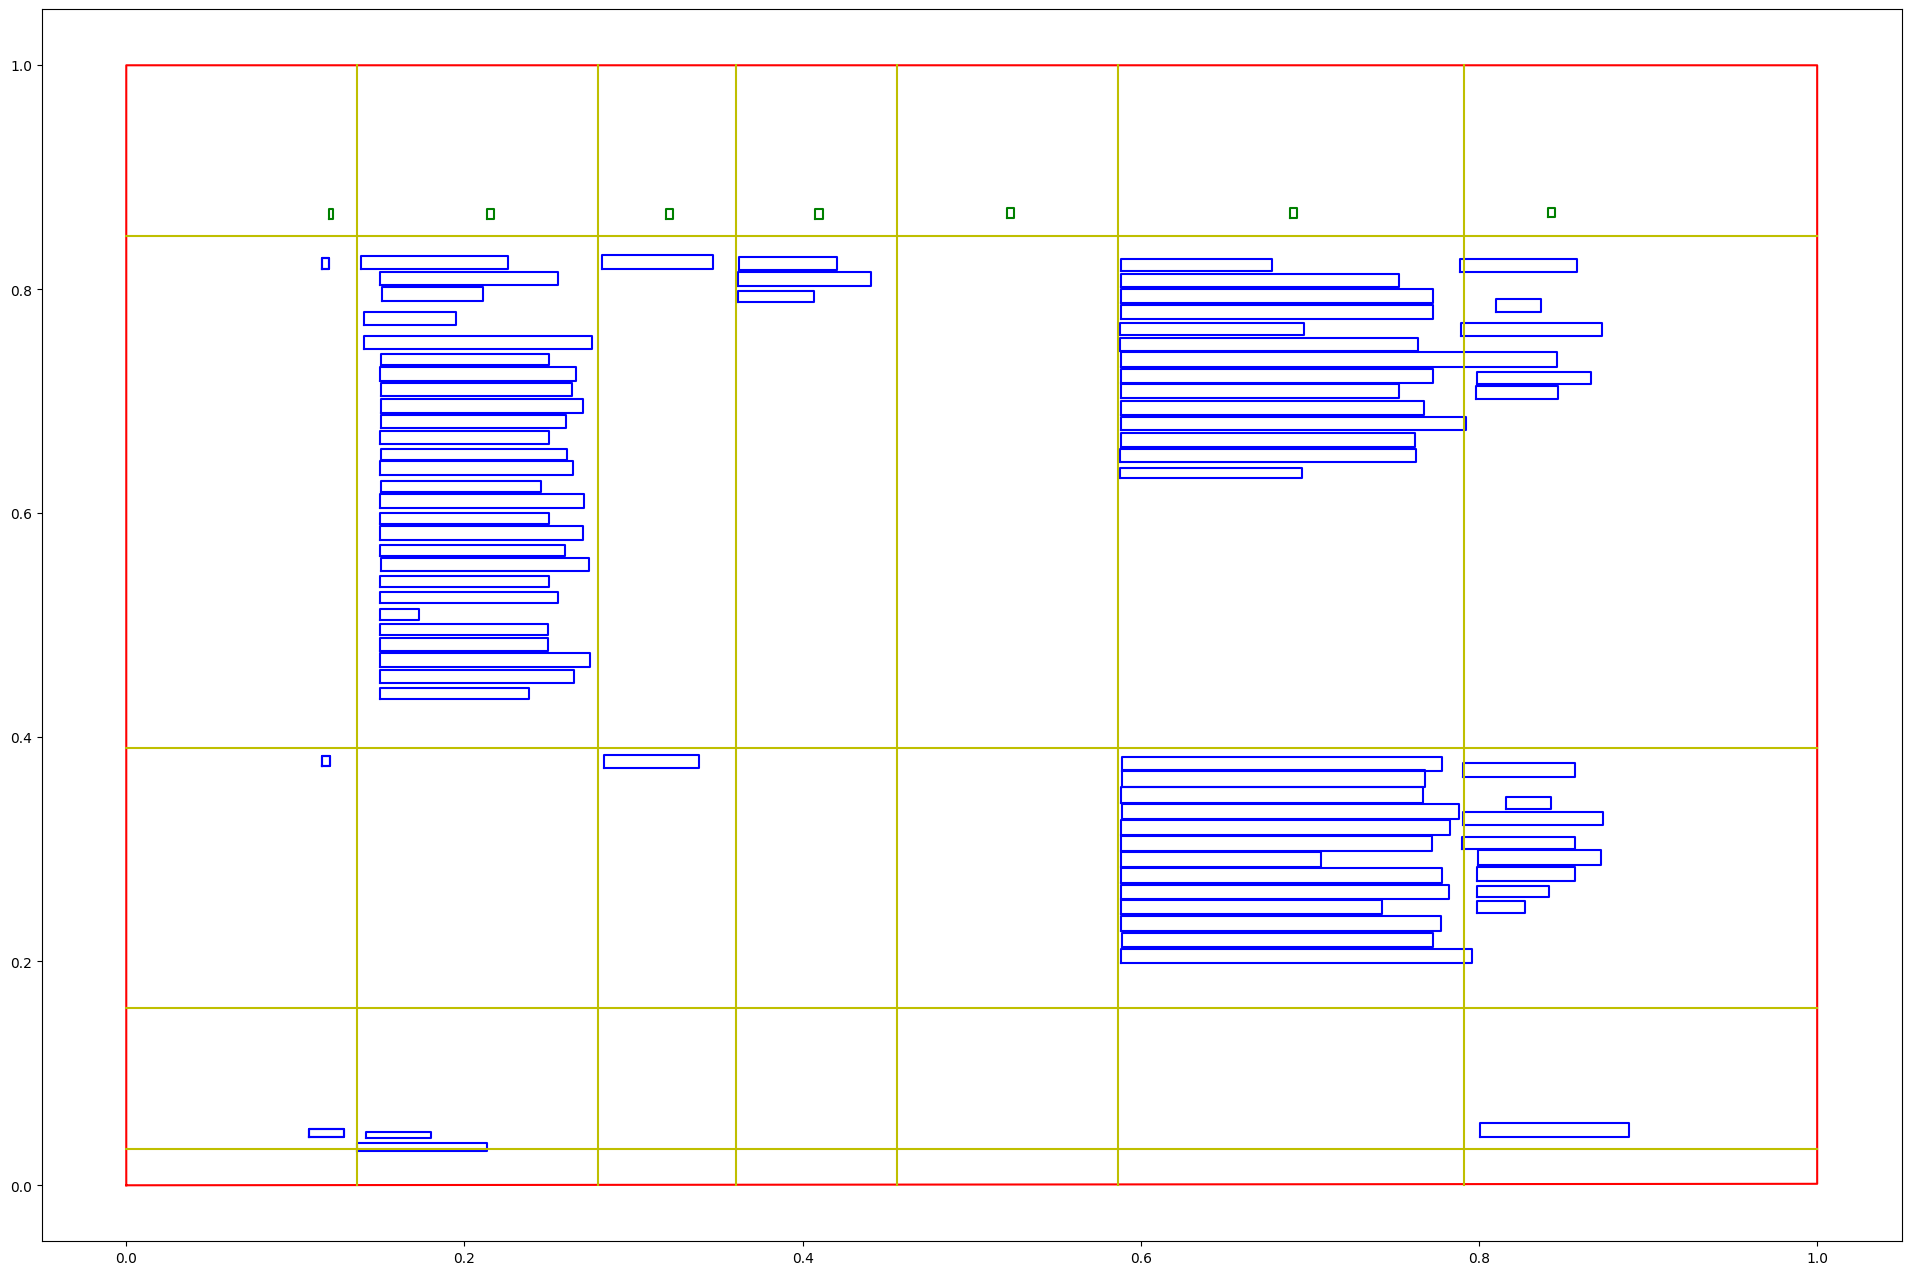

In [15]:
# PLOT

# plot the rectangle of the sheet

# Plot the four corner points of the page object to create a rectangle

plt.figure(figsize=(24, 16))

# Save the page object
page_object = response['Blocks'][0]  # Assuming the page object is the first block

page_polygon = page_object['Geometry']['Polygon']
page_x = [point['X'] for point in page_polygon]
page_y = [point['Y'] for point in page_polygon]
page_x.append(page_x[0])
page_y.append(page_y[0])
plt.plot(page_x, page_y, 'r-')  # Connect the corner points in red

# for line in vertical_lines:
#     # Create and plot lines that extend indefinitely in both directions
#     plt.plot([line, line], [0, 1], 'b-')

for number in numbers:
    # Extract the bounding box coordinates from the line object
    bbox = number['Geometry']['BoundingBox']
    left = bbox['Left']
    top = bbox['Top']
    width = bbox['Width']
    height = bbox['Height']

    # Calculate the coordinates of the bounding box
    x1 = left
    x2 = left + width
    y1 = 1 - top
    y2 = 1 - top + height

    # Plot the bounding box
    plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], 'g-')

for entry_numbers in line_groups[0]:
    # Extract the bounding box coordinates from the line object
    bbox = entry_numbers['Geometry']['BoundingBox']
    left = bbox['Left']
    top = bbox['Top']
    width = bbox['Width']
    height = bbox['Height']
    print("top, left, width, height", top, left, width, height)
    print("y_dividers: ", y_dividers)

    # Calculate the coordinates of the bounding box
    x1 = left
    x2 = left + width
    y1 = 1 - top
    y2 = 1 - top + height

    # Plot the bounding box
    plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], 'b-')

# plot every object in every line group
for group in line_groups:
    for line in group:
        # Extract the bounding box coordinates from the line object
        bbox = line['Geometry']['BoundingBox']
        left = bbox['Left']
        top = bbox['Top']
        width = bbox['Width']
        height = bbox['Height']

        # Calculate the coordinates of the bounding box
        x1 = left
        x2 = left + width
        y1 = 1 - top
        y2 = 1 - top + height

        # Plot the bounding box
        plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], 'b-')

for divider in x_dividers:
    plt.plot([divider, divider], [0, 1], 'y-')

for divider in y_dividers:
    plt.plot([0, 1], [1-divider, 1-divider], 'y-')

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

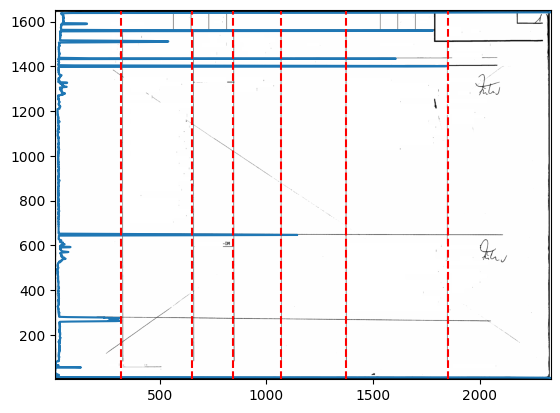

In [16]:
row_list = row_list[::-1]

row_numbers = list(range(1, len(row_list) + 1))

# Create a blank figure and axis
fig, ax = plt.subplots()

# Plot the image as a background using imshow
ax.imshow(image, aspect='auto', extent=[min(row_list), max(row_list), 1, len(row_list)])

# Create the plot on top of the image
plt.plot(row_list, row_numbers)

# Plot vertical lines at the specified x pixel coordinates
for x in x_dividers_absolute:
    ax.axvline(x, color='red', linestyle='--')

y_dividers_for_plot = []

# for y in y_dividers_absolute:
#     y_plot = len(row_list) - y
#     y_dividers_for_plot.append(y_plot)

# # Plot horizontal lines at the specified y pixel coordinates
# for y in y_dividers_for_plot:
#     ax.axhline(y, color='red', linestyle='--')

# plot the values of row_list where the y-axis is the row number and the x-axis is the number of dark pixels
plt.show

In [17]:
# print all LINE objects in the response
for i, block in enumerate(response['Blocks']):
    if block['BlockType'] == 'LINE':
        print(i, block)

1 {'BlockType': 'LINE', 'Confidence': 95.8807144165039, 'Text': 'Tausender', 'Geometry': {'BoundingBox': {'Width': 0.02857515588402748, 'Height': 0.007146726828068495, 'Left': 0.24199359118938446, 'Top': 0.01948457770049572}, 'Polygon': [{'X': 0.24199990928173065, 'Y': 0.01948457770049572}, {'X': 0.27056875824928284, 'Y': 0.01955266296863556}, {'X': 0.27056246995925903, 'Y': 0.026631303131580353}, {'X': 0.24199359118938446, 'Y': 0.02656313218176365}]}, 'Id': 'f65d4394-5eae-402f-a24d-6f807791eaef', 'Relationships': [{'Type': 'CHILD', 'Ids': ['96b2211e-1fb3-4774-86ab-7f3e1e9c1834']}]}
2 {'BlockType': 'LINE', 'Confidence': 96.56513977050781, 'Text': 'Hunderter', 'Geometry': {'BoundingBox': {'Width': 0.028228430077433586, 'Height': 0.007031170651316643, 'Left': 0.2777513265609741, 'Top': 0.019434241577982903}, 'Polygon': [{'X': 0.2777574956417084, 'Y': 0.019434241577982903}, {'X': 0.30597975850105286, 'Y': 0.019501499831676483}, {'X': 0.305973619222641, 'Y': 0.026465412229299545}, {'X': 0.

In [18]:
def categorize_words_by_x_coordinate(line_block_index, x_coordinate):
    
    # Check if there are enough blocks in the response
    if len(response['Blocks']) <= line_block_index:
        print(f'Line block index {line_block_index} not found in the response.')
        return [], []

    # Get the specified LINE block (assuming it's a LINE block)
    line_block = response['Blocks'][line_block_index]
    
    if line_block['BlockType'] != 'LINE':
        print(f'Block {line_block_index} is not a LINE block.')
        return [], []
    
    id_list_1 = []
    id_list_2 = []

    word_list_1 = []
    word_list_2 = []

    # Lists to update the original LINE block's bounding box
    left_values = []
    top_values = []
    right_values = []
    bottom_values = []

    # Iterate through the child blocks (WORD blocks)
    for word_id in line_block['Relationships'][0]['Ids']:
        word_block = next(b for b in response['Blocks'] if b['Id'] == word_id)
        if word_block['BlockType'] == 'WORD':
            # Calculate center_x_coordinate
            left = word_block['Geometry']['BoundingBox']['Left']
            top = word_block['Geometry']['BoundingBox']['Top']
            width = word_block['Geometry']['BoundingBox']['Width']
            height = word_block['Geometry']['BoundingBox']['Height']
            center_x_coordinate = left + (width / 2)
            
            # Categorize based on the given x_coordinate
            if center_x_coordinate <= x_coordinate:
                id_list_1.append(word_block['Id'])
                word_list_1.append(word_block['Text'])
                
                # Collect geometric data to update the original LINE block's bounding box
                left_values.append(left)
                top_values.append(top)
                right_values.append(left + width)
                bottom_values.append(top + height)
            else:
                id_list_2.append(word_block['Id'])
                word_list_2.append(word_block['Text'])
    
    # Update the original LINE block's Relationships, BoundingBox, and Text
    line_block['Relationships'][0]['Ids'] = id_list_1
    line_block['Geometry']['BoundingBox']['Top'] = min(top_values)
    line_block['Geometry']['BoundingBox']['Left'] = min(left_values)
    line_block['Geometry']['BoundingBox']['Width'] = max(right_values) - min(left_values)
    line_block['Geometry']['BoundingBox']['Height'] = max(bottom_values) - min(top_values)
    line_block['Text'] = ' '.join(word_list_1)

    # what I actually need to return here is just the modified line_block and the id_list_2 for creating the new line block, but let's return all 4 lists for now
    return id_list_1, id_list_2, word_list_1, word_list_2

# Replace with the desired x coordinate
x_coordinate = 0.7909362975630612  # Example value, replace with your desired coordinate

# Replace with the desired LINE block index
line_block_index = 63  # Example value, replace with your desired index

list_1, list_2, word_list_1, word_list_2 = categorize_words_by_x_coordinate(line_block_index, x_coordinate)

print('List 1 (center_x_coordinate <=', x_coordinate, '):', list_1)
print('List 2 (center_x_coordinate >', x_coordinate, '):', list_2)


List 1 (center_x_coordinate <= 0.7909362975630612 ): ['3af010e0-ea72-450d-95a7-0dd9749c12a1', 'aa1da924-e18e-4362-8b54-373b4d6de146', 'a3930575-8a2f-46a0-aefe-77efc706df24', 'f91ac7d2-7609-43c4-93ac-8bc22983aacf', '36da2d37-54fb-44cc-87f0-5b9de064e695', 'b31de790-5b64-4a31-81dc-c0eba011eaf0']
List 2 (center_x_coordinate > 0.7909362975630612 ): ['67dd07c9-67f4-4813-bf1c-230e0b5e584e', '8d5774c7-aac2-4282-b30d-654de533bfa0', '078a4003-e1cd-43f5-8947-50de84941503']


In [19]:
print(x_dividers)

[0.13638306968790082, 0.2791791363830697, 0.36041043180846516, 0.4557503206498504, 0.5865754595981189, 0.7909362975630612]


In [20]:
def create_line_from_word_ids(textract_response, word_ids):
    words = [block for block in textract_response['Blocks'] if block['BlockType'] == 'WORD' and block['Id'] in word_ids]

    # Compute the bounding box
    min_top = min([word['Geometry']['BoundingBox']['Top'] for word in words])
    min_left = min([word['Geometry']['BoundingBox']['Left'] for word in words])
    max_width = max([(word['Geometry']['BoundingBox']['Left'] + word['Geometry']['BoundingBox']['Width']) for word in words]) - min_left
    max_height = max([(word['Geometry']['BoundingBox']['Top'] + word['Geometry']['BoundingBox']['Height']) for word in words]) - min_top

    # Combine the words from the word blocks to form the Text attribute
    combined_text = ' '.join([word['Text'] for word in words])

    new_line = {
        'BlockType': 'LINE',
        'Geometry': {
            'BoundingBox': {
                'Top': min_top,
                'Left': min_left,
                'Width': max_width,
                'Height': max_height
            }
        },
        'Text': combined_text,
        'Relationships': [{'Type': 'CHILD', 'Ids': word_ids}]
    }

    return new_line


In [21]:
word_ids_to_combine = list_2
new_line = create_line_from_word_ids(response, word_ids_to_combine)
print(new_line)

{'BlockType': 'LINE', 'Geometry': {'BoundingBox': {'Top': 0.2698722779750824, 'Left': 0.7886708378791809, 'Width': 0.05759014468640089, 'Height': 0.01226129848510027}}, 'Text': 'b) Satzung v.', 'Relationships': [{'Type': 'CHILD', 'Ids': ['67dd07c9-67f4-4813-bf1c-230e0b5e584e', '8d5774c7-aac2-4282-b30d-654de533bfa0', '078a4003-e1cd-43f5-8947-50de84941503']}]}
